In [1]:
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data =  [['ND', 7126, 1],
         ['SD', 6263, 1],
         ['IA', 4931, 1],
         ['WI', 4593, 0],
         ['NE', 4341, 1],
         ['MS', 4257, 1],
         ['AL', 4154, 1],
         ['UT', 4137, 1],
         ['TN', 4127, 1],
         ['ID', 4083, 1],
         ['LA', 4043, 1],
         ['AR', 4038, 1],
         ['FL', 3929, 1],
         ['IL', 3851, 0],
         ['MT', 3713, 1],
         ['SC', 3606, 1],
         ['NV', 3572, 0],
         ['AZ', 3562, 0],
         ['GA', 3514, 0],
         ['MO', 3468, 1],
         ['OK', 3443, 1],
         ['RI', 3434, 0],
         ['TX', 3417, 1],
         ['KS', 3281, 1],
         ['MN', 3207, 0],
         ['IN', 3125, 1],
         ['WY', 2991, 1],
         ['NJ', 2866, 0],
         ['NC', 2797, 1],
         ['DE', 2732, 0],
         ['NY', 2719, 0],
         ['AK', 2710, 1],
         ['KY', 2705, 1],
         ['NM', 2617, 0],
         ['DC', 2551, 0],
         ['ML', 2547, 0],
         ['MA', 2487, 0],
         ['CA', 2470, 0],
         ['MI', 2294, 0],
         ['CO', 2275, 0],
         ['VA', 2251, 0],
         ['CT', 2191, 0],
         ['OH', 2141, 1],
         ['PA', 1836, 0],
         ['WV', 1585, 1],
         ['WA', 1541, 0],
         ['OR', 1196, 0],
         ['HI', 1126, 0],
         ['NH', 918, 0],
         ['ME', 572, 0],
         ['VT', 383, 0]
        ]

In [2]:
states = []
for i in range(len(data)):
    states.append(data[i][0])
    
covid_density = []
for i in range(len(data)):
    covid_density.append(data[i][1])
    
rep_vs_dem = []
for i in range(len(data)):
    rep_vs_dem.append(data[i][2])
    
data = pd.DataFrame({'State':states,
                     'CovidDensity':covid_density,
                     'RepDem':rep_vs_dem})

/Users/bradythompson/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


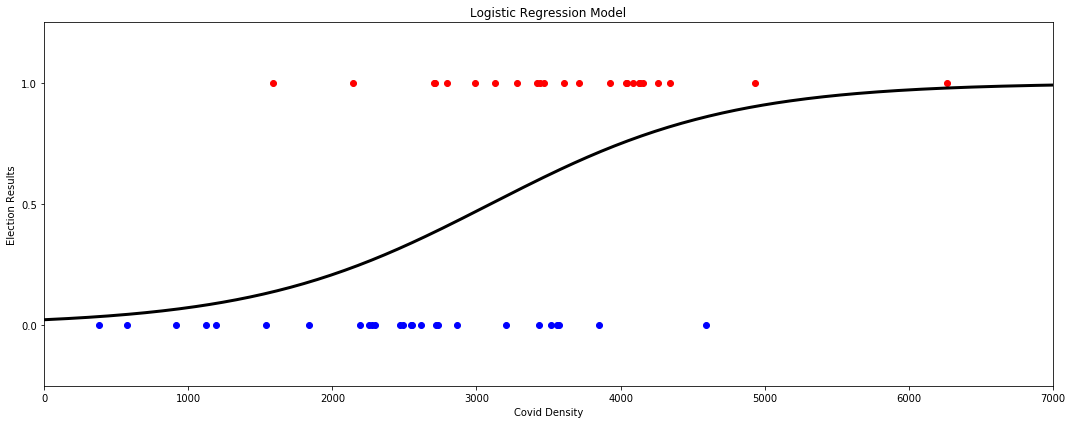

In [3]:
# import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.special import expit

X = np.array(data['CovidDensity']).reshape(-1,1)
y = np.array(data['RepDem']).reshape(-1,1).reshape(51,)


# Fit the classifier
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X, y)

# and plot the result
plt.figure(1, figsize=(15, 6))
plt.clf()
plt.scatter(data[data['RepDem'] ==1]['CovidDensity'] , data[data['RepDem'] ==1]['RepDem'], color='red')
plt.scatter(data[data['RepDem'] ==0]['CovidDensity'] , data[data['RepDem'] ==0]['RepDem'], color='blue')
X_test = np.linspace(0, 7000, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='black', linewidth=3)

plt.ylabel('Election Results')
plt.xlabel('Covid Density')
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(0, 7000)
plt.title('Logistic Regression Model')
plt.tight_layout()
plt.show()

In [13]:
print(clf.coef_)
print(clf.intercept_)

[[0.00121496]]
[-3.76170422]


# now let's do the same thing with pymc3

In [74]:
import pymc3 as pm
import theano.tensor as tt


# challenger_data = [[ 66.,   0.],
#  [ 70.,   1.],
#  [ 69.,   0.],
#  [ 68.,   0.],
#  [ 67.,   0.],
#  [ 72.,   0.],
#  [ 73.,   0.],
#  [ 70.,   0.],
#  [ 57.,   1.],
#  [ 63.,   1.],
#  [ 70.,   1.],
#  [ 78.,   0.],
#  [ 67.,   0.],
#  [ 53.,   1.],
#  [ 67.,   0.],
#  [ 75.,   0.],
#  [ 70.,   0.],
#  [ 81.,   0.],
#  [ 76.,   0.],
#  [ 79.,   0.],
#  [ 75.,   1.],
#  [ 76.,   0.],
#  [ 58.,   1.]]


# temperature = [item[0] for item in challenger_data]
# D = [item[1] for item in challenger_data]

covid_density = list(data['CovidDensity'])
election_results = list(data['RepDem'])

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=-3.76)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*covid_density + alpha)))

In [75]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=election_results)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[10000::2]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 2 chains for 1_000 tune and 120_000 draw iterations (2_000 + 240_000 draws total) took 68 seconds.
The number of effective samples is smaller than 10% for some parameters.


/Users/bradythompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/bradythompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app


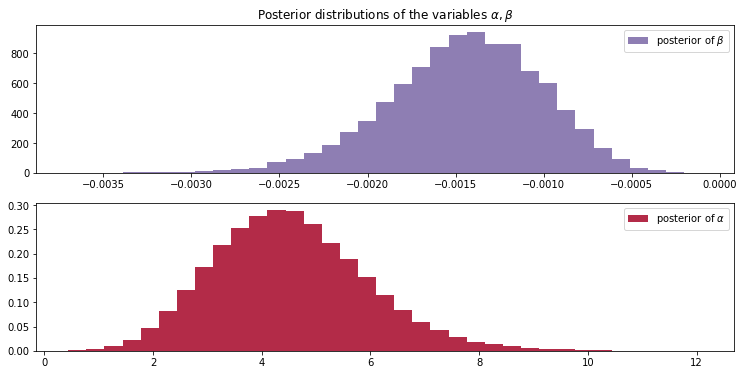

In [76]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [77]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(min(covid_density) - 5, max(covid_density)+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

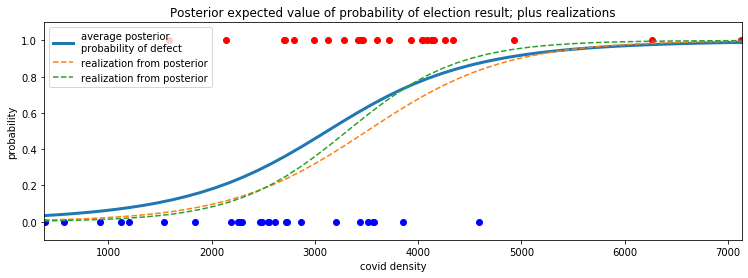

In [78]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[3, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(data[data['RepDem'] ==1]['CovidDensity'] , data[data['RepDem'] ==1]['RepDem'], color='red')
plt.scatter(data[data['RepDem'] ==0]['CovidDensity'] , data[data['RepDem'] ==0]['RepDem'], color='blue')
plt.title("Posterior expected value of probability of election result; \
plus realizations")
plt.legend(loc="upper left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("covid density");